# Explainable AI - Shapley Values

In this example, we use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality).
We have already explored this dataset in a dedicated exercise for regression, so we won't discuss the exploratory data analysis or model considerations here.

Instead, we will focus on how to make predictions explainable *post hoc*, i.e., after they have been made. This means we can use any (black box) prediction model and then use Shapley values to explore how the features contribute to the model - both on  a global level, as well as for individual predictions.

Shapley values originate from game theory and we can use them to analyze how much a given feature contributes to the prediction.
We can interpret the features as "players" that work together to achieve an outcome, in our case, the prediction of a machine learning model.
Just like in a, say, football game, the "players" have different strenghts and the team is not just a set of players but each player contributes in relation to the other players on the "team" (our model).

In this example, we will use the [SHAP](https://shap.readthedocs.io/en/latest/) package for this.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import shap

# Data and model

Load the data from the internet archive, define the model, and run some predictions.
Here, we do not do any exploratory data analysis

In [3]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    sep=';')
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]

# split into training and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

model = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=15)
model.fit(X_train, y_train)

predictions = X_test.copy()
y_hat = model.predict(predictions)
predictions.loc[:,'y_hat'] = y_hat
predictions.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,y_hat
1469,7.3,0.980,0.05,2.10,0.061,20.0,49.0,0.99705,3.31,0.55,9.7,5.066667
1144,7.3,0.320,0.23,2.30,0.066,35.0,70.0,0.99588,3.43,0.62,10.1,5.466667
1418,7.8,0.530,0.01,1.60,0.077,3.0,19.0,0.99500,3.16,0.46,9.8,5.266667
999,6.4,0.690,0.00,1.65,0.055,7.0,12.0,0.99162,3.47,0.53,12.9,5.400000
732,7.3,0.835,0.03,2.10,0.092,10.0,19.0,0.99660,3.39,0.47,9.6,4.533333


# Global interpretation

Now we look at the global properties of our model and focus on the features using Shapley values.

First, we determine which features are the most important overall:

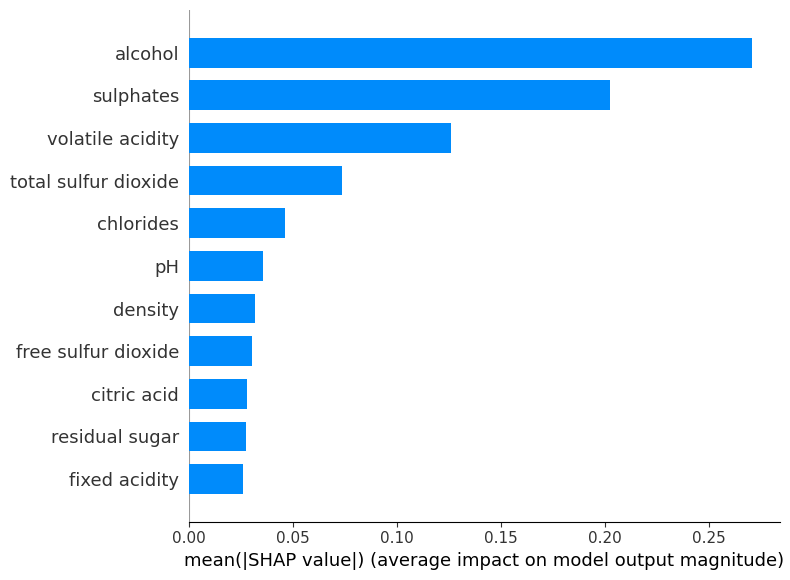

In [4]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

The most important ones are: alcohol content, sulphates, and volatile acidity. 
Remembering our previous exercise, these are also the features that are most highly correlated with the label / target variable, so this explanation fits nicely with our expectation.

We can look at this in more detail by exploring the impact on low or high values of these features:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


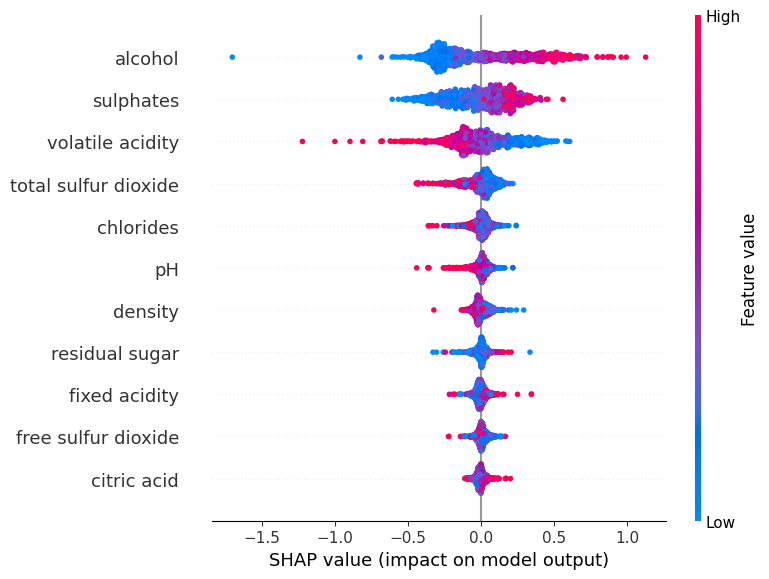

In [19]:
shap.summary_plot(shap_values, X_train)

Next, we look at [dependence plots](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html).
These scatter plots allow us to explore how the a single feature contributes to the predictions in more detail. Each point in the scatter-plot is a single prediction.

The x-axis show the numerical value of the feature we want to test (e.g. alcohol content in this example), the y-axis the corresponding Shapley value for this feature.
In this example we can see that the importance raises with increasing levels of alcohol 

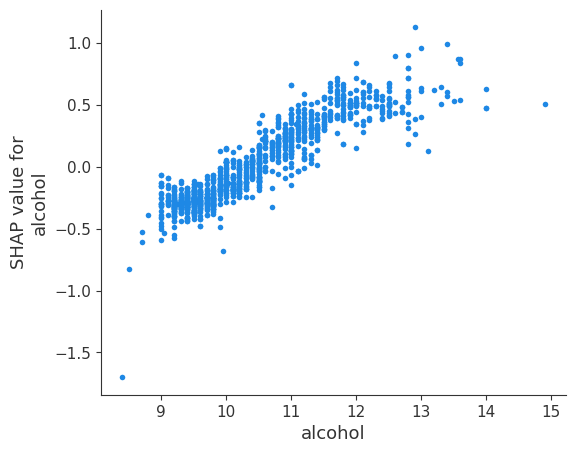

In [20]:
shap.dependence_plot('alcohol', shap_values, X_train, interaction_index=None)


We can also add a second feature variable to this plot. 
This allows us to analyse whether there are any interactions between these two features. Such an interaction would show up as a distinct pattern in this plot.

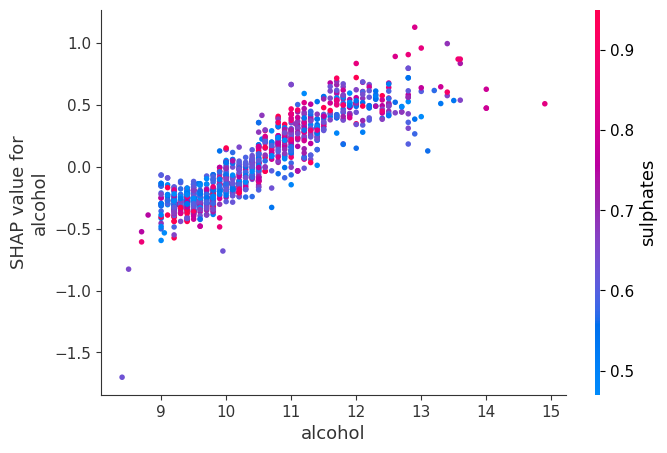

In [21]:
shap.dependence_plot('alcohol', shap_values, X_train, interaction_index='sulphates')


Further, we can look at all the interactions between the features. The diagonal show the same plots as above, and then we investigate if or how any pair of features interacts in the prediction.

In [35]:
explainer = shap.TreeExplainer(model)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


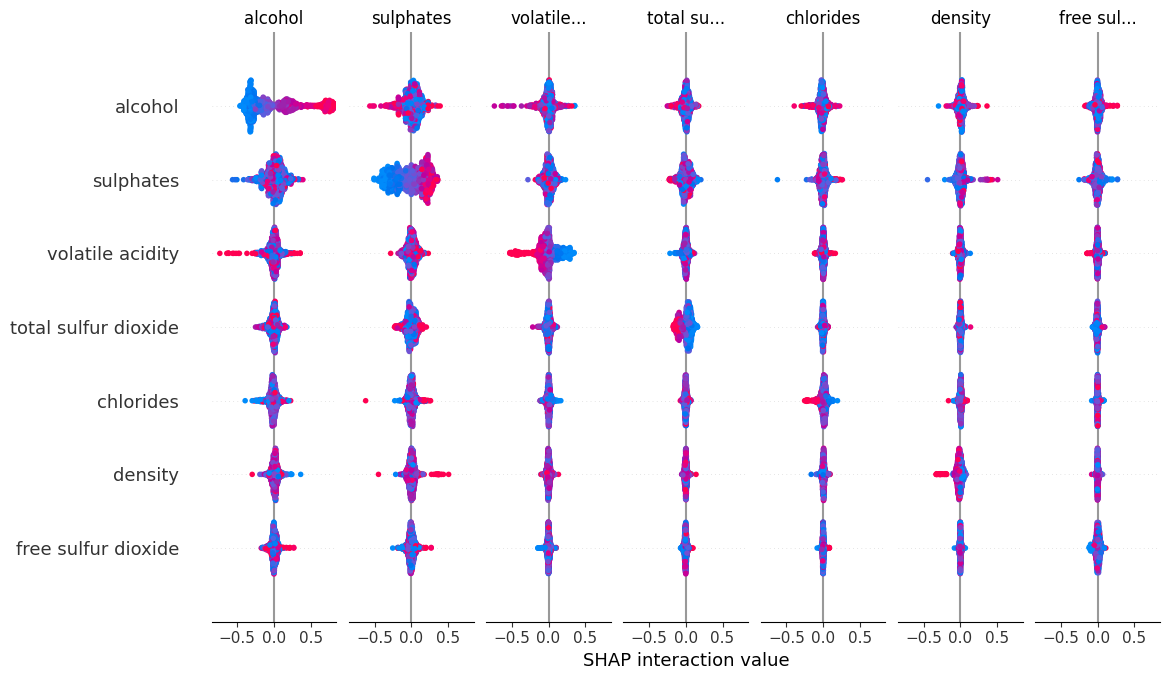

In [38]:
shap_interaction = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction, X_train)

# Local interpretation

Next, we look at individual predictions. the ```base value``` is the mean prediction across the training data (this is all the model sees during training). The prediction for the current sample is denoted by ```f(x)```. 

We can interprete this in the following way:
The predictions are split into the average (base) value plus the deviations that originate from the values of the features for a specific event and their interaction.
Thus, we can express this as pseudo-code:
```
prediction = model.predict(data)
mean_pred  = mean(prediction)

Shapley_factor(event) = sum(shap_interaction(event))
prediction(event) = mean_pred + Shapley_factor(event)
```



In [51]:
# these are all predicted values 
# note that we use the training set here (which we normally would not do!) to illustrate how the mechanisms work
# and reproduce the numbers.
y_pred = model.predict(X_train)
mean_pred = np.mean(y_pred)

# now we calculate the Shapley contribution for a specific event (index 0 in this case)
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {0:.2f}".format(y_pred[0]))
print("Mean prediction + interaction values: {0:.2f}".format(mean_pred+sum_shap))

Model prediction: 6.13
Mean prediction + interaction values: 6.13


Then, the individual features are shown with an indication how much they influence the deviatoin from the base value for in this event. Features in red indicate that they push the value up, features in blue push the value down.  The relative size indicates by how much.

In [52]:
sample_id = 0


# here we use the test data again.
# Note that then the base value will differ from the mean predictions as the 
# SHAP package has not seeen the test data and we expect some statistical fluctuations
shap_values = explainer.shap_values(predictions)

#initialise JavaScript for the viusalization
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[sample_id], 
                predictions.iloc[[sample_id]])